## Exploratory Data Analysis del Caso base

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp, quad
import numpy as np
from scipy.misc import derivative as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [7]:
γ = 1/2.4
fecha_inicio = pd.to_datetime("27-february-2020")
r = 0.7
red_traf = r
inicio_red = 25
f = 0.9
q = 0.1356473594548552
ν = 5/12
η = 1/7
ϵ = 1/1.4
θ = 1/2.4
pa, pm, ps = 0.5, 0.476, 0.024
σ = 1/4.7
ξ = 1/4
τ = 1/5

## Defunciones

In [8]:
defun = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_miZMVM.csv",
           index_col = 0);
acumdefun = defun.cumsum(axis = 1).iloc[:, :75]

Elegimos 5 ciudades al azar para ver la forma en que se comportan las series de tiempo de defunciones:

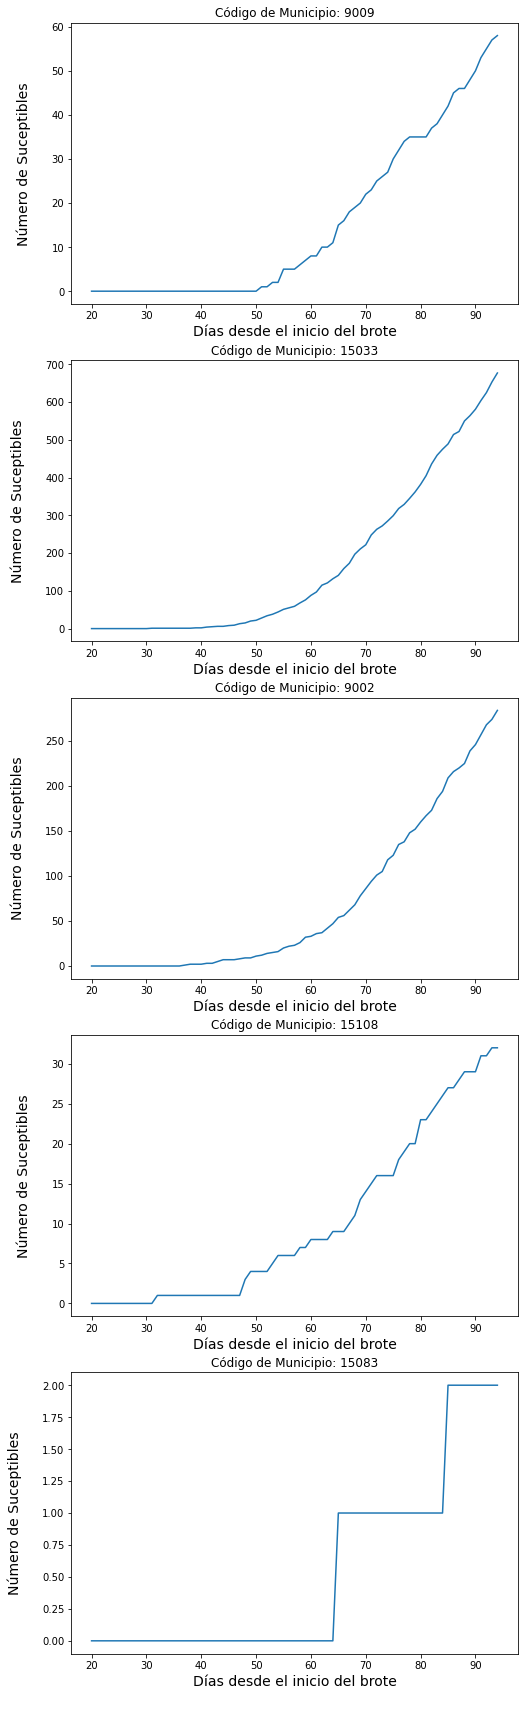

In [11]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))

for i in range(5):
    ax[i].plot(range(20, 95), acumdefun.iloc[index[i]])
    ax[i].set_title('Código de Municipio: {}'.format(acumdefun.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde el inicio del brote\n', fontsize = 14)

Parece que se le puede ajustar una curva logísitca de la forma $f(x) = A + \frac{(K-A)}{C+Qe^{-B(t+t0) + J}}$. Habiendo inspeccionado todas las series del tiempo, hay algunas que no se ajustan bien (tienen muy pocos casos y hay un brinco tipo función escalera), suponemos que en estas ciudades no se registraron casos.

In [18]:
D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))

In [19]:
paramsD = []

for i in range(47):

    try:
        y = acumdefun.iloc[i, :75]
        fit = optimize.curve_fit(D, list(range(20, 95)), y, maxfev=1000)[0]
        paramsD.append(fit)
    except: # los que no se ajustan bien tienen ínidces 17, 28
        paramsD.append([0, 1, 0, 0, 0])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_27664\2150841193.py:1: RuntimeWarning: overflow encountered in exp
  D = lambda t, K, C, Q, B, J, A, t0: A + (K-A)/(C+Q*np.exp(-B*t + J))
C:\Users\Edgar Trejo\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Veamos cómo se ajusta nuestro modelo de defunciones:

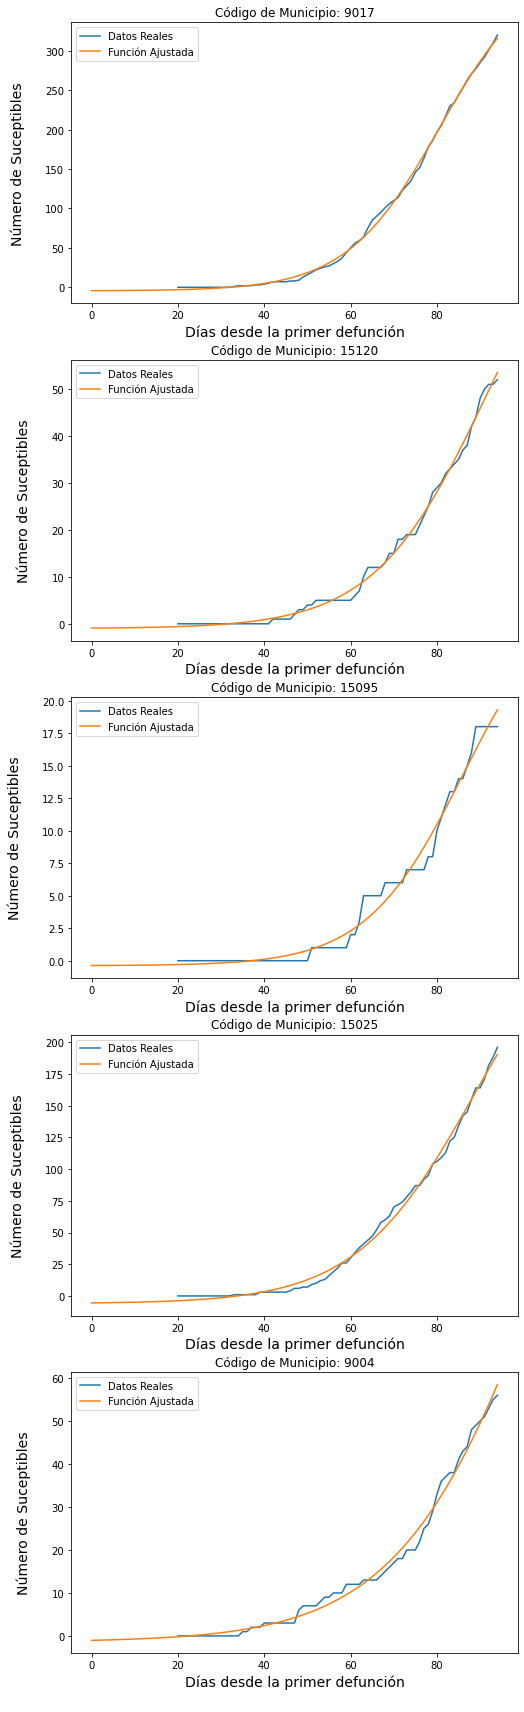

In [20]:
index = np.random.randint(low = 0, high = 47, size = 5)
fig, ax = plt.subplots(5, figsize = (8, 30))
t = np.array(range(95))

for i in range(5):
    ax[i].plot(range(20, 95), acumdefun.iloc[index[i]], label = 'Datos Reales')
    ax[i].plot(t, D(t, *paramsD[index[i]]), label = 'Función Ajustada')
    ax[i].set_title('Código de Municipio: {}'.format(acumdefun.index[index[i]]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)
    ax[i].set_xlabel('Días desde la primer defunción\n', fontsize = 14)
    ax[i].legend()

plt.show()

De la ecuación diferencial tenemos que $\frac{dD_i}{dt} = q\xi H_i(t) \Rightarrow H_i(t) = \frac{1}{q\xi}\cdot \frac{dD_i}{dt} $

In [21]:
H = lambda t, i: 1/(q*ξ) * dt(D, t, n=1, args = (*paramsD[i], ))

Además, $\frac{dH_i}{dt} = \sigma I_{ss_i} - q\xi H_i - (1-q)\tau H_i \Rightarrow I_{ss_i}(t) = \frac{1}{\sigma}\left(\frac{dH_i}{dt} + \left(q\xi + (1-q)\tau\right)H_i \right)$

In [22]:
Iss = lambda t, i : (dt(H, t, n=1, args = (i,)) + (q*ξ + (1-q)*τ)*H(t, i))/σ

Luego, $\frac{dI_{ss_i}}{dt} = \theta p_s I_{p_i} - \sigma I_{ss_i}$, de donde $I_{p_i}(t) = \frac{1}{\theta p_s}\left(\frac{dI_{ss_i}}{dt} + \sigma I_{ss_i} \right)$

In [23]:
Ip = lambda t, i: 1/(θ*ps)*(dt(Iss, t, n=1, args = (i, )) + σ*Iss(t, i))

In [24]:
Ip0 = [int(Ip(0, i)) for i in range(47)]

Luego $\frac{dI_{p_i}}{dt} = \epsilon E_i(t) - \theta I_{p_i}$

$E_i(t) = \frac{1}{\epsilon}\left(\frac{dI_{p_i}}{dt}+\theta I_{p_i}\right)$

In [25]:
E = lambda t, i: 1/(ϵ)*(dt(Ip, t, n=1, args = (i, )) + θ*Ip(t, i))

In [26]:
E0 = [int(E(0, i)) for i in range(47)]

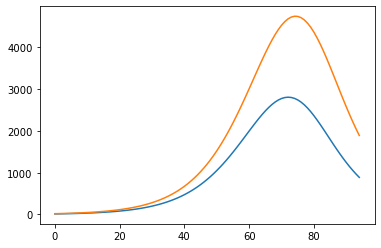

In [27]:
t = np.array(range(95))
plt.plot(t, E(t, 10))
plt.plot(t, Ip(t, 10))

In [28]:
E(0, 10)

13.302665306562247

$\frac{dE_i}{dt}=\lambda_i(t)S_i(t) - \epsilon E_i$

$\frac{dE_i}{dt}= -\frac{dS_i}{dt} - \epsilon E_i$

$\frac{dS_i}{dt}=-\epsilon E_i - \frac{dE_i}{dt}$

$-\epsilon E_i - \frac{dE_i}{dt} = -\lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\epsilon E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

$S_i(\tau) - S_i(0) = - \epsilon \displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + E_i(0)$

$S_i(\tau) = -\epsilon\displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + S_i(0)$

In [29]:
S = lambda t, i: -ϵ*quad(E, 0, t, args = (i, ))[0] - E(t,i) + (pob[i] - Ip0[i])

In [30]:
T = np.array(range(95))

In [31]:
Sarray = np.zeros((47, 95))

In [35]:
for i in range(47):
    Sarray[i] = [S(t, i) for t in T]

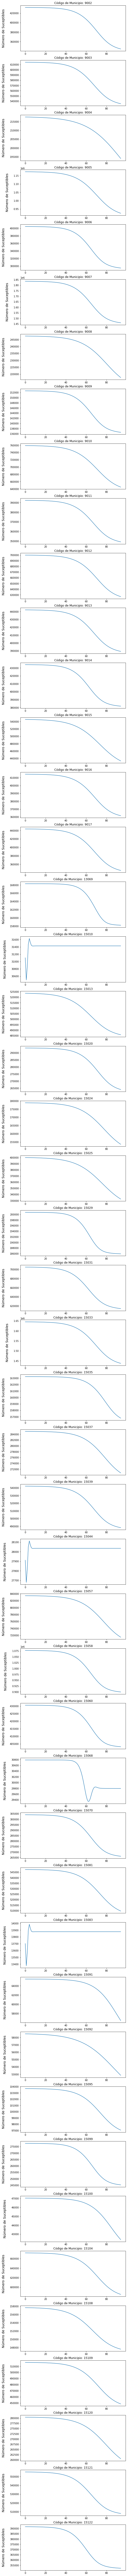

In [37]:
fig, ax = plt.subplots(47, figsize = (8, 200))

t = np.array(range(95))
for i in range(47):
    ax[i].plot(t, Sarray[i])
    ax[i].set_title('Código de Municipio: {}'.format(acumdefun.index[i]))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)

Para el resto de los infectados, podemos resolver sus ecuaciones diferenciales de manera numérica:

In [38]:
def IaEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(47)
    
    Ia = lambda i: X[i]
            
    for i in range(47):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pa*Ip(t, i) - γ*Ia(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Ia0 = np.zeros(47)
indicesCasos = [3, 5, 34]
Ia0[indicesCasos] = 1


solIa = solve_ivp(IaEDO, (0, 94), Ia0, t_eval = tdata)

In [39]:
Ia = lambda t, i: solIa.y[i, np.array(t).astype(int)]

In [40]:
def ImEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(47)
    
    Im = lambda i: X[i]
            
    for i in range(47):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pm*Ip(t, i) - γ*Im(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Im0 = np.zeros(47)


solIm = solve_ivp(ImEDO, (0, 94), Im0, t_eval = tdata)

In [41]:
Im = lambda t, i: solIm.y[i, np.array(t).astype(int)]

In [42]:
casos = pd.read_csv('https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/positivos_miZMVM.csv',
        index_col = 0, dtype = {'cve_ent':str});
acumcasos = casos.cumsum(axis = 1).iloc[:, :95]

In [33]:
pob = pd.read_csv('https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_miZMVM.csv',
                 index_col = 0, dtype = {'cve_umun':str})

In [43]:
pob = pob['pop']

KeyError: 'pop'

$-\epsilon E_i - \frac{dE_i}{dt} = -\lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\epsilon E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

In [44]:
λ = lambda t, i: (dt(E, t, n = 1, args = (i, )) + ϵ*E(t,i) )/ Sarray[i, t]

In [45]:
es = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_entre_semana_por_cve_umun_2020.csv",
                index_col = 0, dtype = {'origen':str})

s = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_sabado_por_cve_umun_2017.csv",
                index_col = 0, dtype = {'origen':str})

d = pd.read_csv("D:/Edgar Trejo/Universidad/BioMatematica/Modeling COVID-19 Spreading in the ZMVM/data/cleandata/viajes/viajes_domingo_por_cve_umun_2017.csv",
                index_col = 0, dtype = {'origen':str})

In [457]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [459]:
dfs = []

for t in range(95):
    wd = (fecha_inicio.weekday() + t) % 7
    if wd == 5:  #sábado
        df = s.copy()
    elif wd == 6: #domingo
        df = d.copy()
    else:
        df = es.copy()
            
    if t > inicio_red:
        df = df.multiply(r)
        
    df = pd.concat([df, df.T], axis = 1)
        
    df['t'] = t
    df['i'] = range(47)
    df['Ia'] = range(47)
    df['Im'] = range(47)
    df['Ip'] = range(47)
    df['y'] = range(47)
    
    for i in range(47):
        df.iloc[i, -4] = Ia(t, i)
        df.iloc[i, -3] = f*Im(t, i)
        df.iloc[i, -2] = Ip(t, i)
        df.iloc[i, -1] = λ(t, i)
        
    dfs.append(df)

In [460]:
main = pd.concat(dfs, axis = 0)

In [461]:
main.head()

,09002,09003,09004,09005,09006,09007,09008,09009,09010,09011,...,15109,15120,15121,15122,t,i,Ia,Im,Ip,y
09002,232346.0,12482.0,896.0,47279.0,3891.0,10854.0,1464.0,0.0,5154.0,693.0,...,13440.0,725.0,5746.0,2383.0,0,0,0.0,0.0,14.176930,0.000019
09003,9509.0,620410.0,9251.0,23693.0,14445.0,125925.0,71294.0,5832.0,46182.0,33780.0,...,1387.0,1002.0,1674.0,2385.0,0,1,0.0,0.0,22.745223,0.000021
09004,1298.0,8531.0,138682.0,2708.0,1243.0,3638.0,3852.0,143.0,34823.0,226.0,...,40.0,0.0,739.0,760.0,0,2,0.0,0.0,21.937170,0.000052
09005,31628.0,25975.0,5323.0,890103.0,9951.0,20588.0,1820.0,277.0,10318.0,3118.0,...,8928.0,747.0,5618.0,1944.0,0,3,1.0,0.0,83.484708,0.000040
09006,554.0,14372.0,1174.0,7421.0,319991.0,160054.0,1378.0,621.0,5512.0,4037.0,...,1887.0,169.0,630.0,1359.0,0,4,0.0,0.0,18.287753,0.000027


In [556]:
train_X, test_X, train_Y, test_Y = train_test_split(main.iloc[:, :-1], main.iloc[:, -1], test_size = 0.25, random_state = 42)

In [557]:
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [558]:
Y = rf.predict(main.iloc[:, :-1])

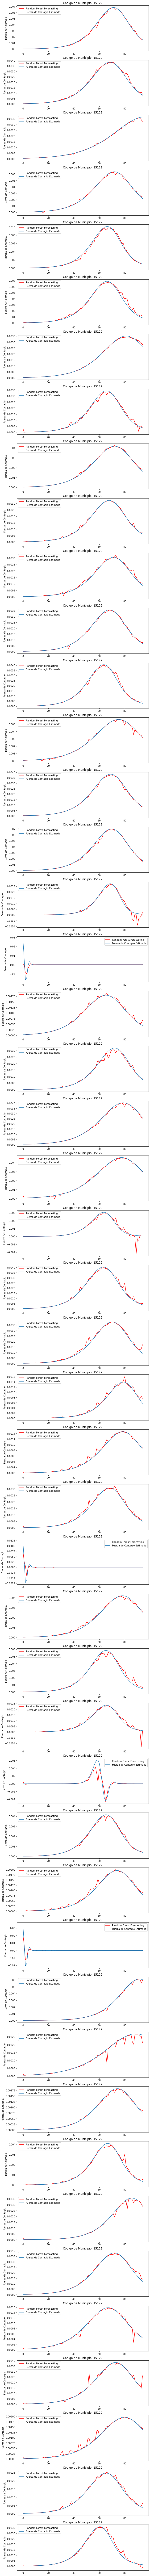

In [559]:
fig, ax = plt.subplots(47, figsize = (10, 200))

t = np.array(range(95))
for k in range(47):
    ax[k].plot(Y[[47*i + k for i in range(95)]], color = 'r', label = 'Random Forest Forecasting')
    ax[k].plot(t, λ(t, k), label = 'Fuerza de Contagio Estimada')
    ax[k].legend()
    ax[k].set_ylabel('Fuerza de Contagio')
    ax[k].set_title('Código de Municipio: {}'.format(acumdefun.index[i]))

In [466]:
main.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/ABTrf.csv")

In [467]:
dfx0 = {'Ip0':Ip0, 'E0': E0}

In [468]:
df = pd.DataFrame(dfx0)

In [469]:
df.index = es.index

In [470]:
df.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/x0.csv")

Intento para ajustar la fuerza de infección del modelo de calveti:

In [51]:
viajes = [es, s, d]

In [46]:
def Ω(i, j, d):
    wd = (fecha_inicio.weekday() + d) % 7
    if wd == 5:
        p = viajes[1].iloc[i, j] / sum(viajes[1].iloc[i])
    elif wd == 6:
        p = viajes[2].iloc[i, j] / sum(viajes[2].iloc[i])
    else:
        p = viajes[0].iloc[i, j] / sum(viajes[0].iloc[i])
        
    if d > inicio_red:
        p = (1-red_traf)*p
                
    return p

In [47]:
Ω = np.vectorize(Ω)

In [49]:
sols = []

In [52]:
for t in range(95):
    A = np.zeros((47, 47))
    b = np.zeros(47)
    for i in range(47):
        for j in range(47):
            A[i, j] = Ω(i, j, t)* sum(( Ω(m, j, t) * (Ip(t, m) + Ia(t, m) + (1-f)*Im(t, m))  for m in range(47)))
        b[i] = λ(t, i)
    X = np.linalg.lstsq(A, b, rcond = None)[0]
    sols.append(X)

In [ ]:
Sols = np.array(sols)

In [ ]:
plt.plot(Sols[:, 0])

In [ ]:
def β(t, k, Θ = Sols):
    return Θ[int(t), k]

β = np.vectorize(β)